In [1]:
# !Convert*solver_mosek.py*w*sh*

In [2]:
import time
import math

import numpy

import mosek

In [3]:
def mosek_set_model(mu, nu, c, task):
    m, n = c.shape
    
    inf = 0.
    
    task.appendvars(m*n)
    task.appendcons(m+n)
    
    task.putvarboundlist(
        range(m*n),
        [mosek.boundkey.lo]*(m*n),
        [0.]*(m*n),
        [inf]*(m*n)
    )
    
    for i in range(m):
        task.putarow(
            i,
            range(i*n, (i+1)*n),
            [1.]*n
        )
    task.putconboundlist(
        range(0, m),
        [mosek.boundkey.fx]*m,
        mu,
        mu
    )
    
    for i in range(n):
        task.putarow(
            i+m,
            range(i, i+m*n, n),
            [1.]*m
        )
    task.putconboundlist(
        range(m, m+n),
        [mosek.boundkey.fx]*n,
        nu,
        nu
    )
    
    task.putclist(range(m*n), c.reshape(m*n))
    
    task.putobjsense(mosek.objsense.minimize)

def solve_mosek(
    p,
    scale=None,
    mtd=None, sol=None, var=None, it=None,
    log=None, stat=False, title="",
    *args, **kwargs
):    
    if stat:
        start_time = time.time()
    
    m, n = p.c.shape
    
    if scale is None:
        scale = math.sqrt(m * n)
    
    with mosek.Env() as env:
        env.set_Stream(mosek.streamtype.log, log)
        
        with env.Task() as task:
            task.set_Stream(mosek.streamtype.log, log)
            
            task.putintparam(mosek.iparam.optimizer, mtd)
            
            mosek_set_model(scale*p.mu, scale*p.nu, p.c, task)
            
            if stat:
                end_time = time.time()
            
            task.optimize()
            
            xx = [0.] * (m*n)
            task.getxx(sol, xx)
            
            p.s = numpy.array(xx).reshape(m, n) / scale
    
            if stat:
                setup_time = end_time - start_time
                s = {
                    "title": title,
                    "size": [m, n],
                    "loss": task.getprimalobj(sol) / scale,
                    "vars": task.getintinf(var),
                    "iters": task.getintinf(it),
                    "setup": setup_time,
                    "solve": task.getdouinf(mosek.dinfitem.optimizer_time),
                }
                return p, s
            else:
                return p

In [4]:
def solve_mosek_primal_simplex(p, *args, **kwargs):
    return solve_mosek(
        p,
        mtd=mosek.optimizertype.primal_simplex,
        sol=mosek.soltype.bas,
        var=mosek.iinfitem.opt_numvar,
        it=mosek.iinfitem.sim_primal_iter,
        title="MOSEK, simplex for primal",
        *args, **kwargs
    )

def solve_mosek_dual_simplex(p, *args, **kwargs):
    return solve_mosek(
        p,
        mtd=mosek.optimizertype.dual_simplex,
        sol=mosek.soltype.bas,
        var=mosek.iinfitem.opt_numvar,
        it=mosek.iinfitem.sim_dual_iter,
        title="MOSEK, simplex for dual",
        *args, **kwargs
    )

def solve_mosek_interior_point(p, *args, **kwargs):
    return solve_mosek(
        p,
        mtd=mosek.optimizertype.intpnt,
        sol=mosek.soltype.itr,
        var=mosek.iinfitem.opt_numvar,
        it=mosek.iinfitem.intpnt_iter,
        title="MOSEK, interior point",
        *args, **kwargs
    )

In [5]:
# !ConvertEnd*

In [6]:
# !Convert*solver_mosek_test.py*w*sehx*

In [7]:
# !Switch*
from handler import FigureHandler
from dataset import ot_2d_Caffarelli
from stats import Statistics
# !SwitchCase*
# import font
# from handler import FigureHandler
# from dataset import ot_2d_Caffarelli
# from stats import Statistics
# from solver_mosek import solve_mosek_primal_simplex, solve_mosek_dual_simplex, solve_mosek_interior_point
# !SwitchEnd*

In [8]:
# !Switch*
fh = FigureHandler(redir=True)
# !SwitchCase*
# fh = FigureHandler(sav=True, disp=False, ext=".pgf", redir=True)
# !SwitchEnd*

Log-01-20180107-132341-327668.log created


In [9]:
stat = Statistics(
    probs=[
        ot_2d_Caffarelli(100, 100, 1)
    ],
    prob="Test problems",
    log=fh.write,
)

In [10]:
stat.test(solve_mosek_primal_simplex, title="MOSEK, test", memory=True, prog=fh.write, clean=False)
stat.output_last()

Testing 0/1
Problem: Test problems
Title: MOSEK, test
Function name: solve_mosek_primal_simplex
Time: 0.09376+-0.00000~[0.09375596046447754]
Setup time: 0.00527+-0.00000
Solve time: 0.01239+-0.00000
Memory usage: 7.95312+-0.00000
Variables: [5700]
Average iterations: [1056]
Loss: 1.1285464e+00+-0.0000000e+00
Check loss: 1.1285464e+00+-0.0000000e+00~[0[2]]
Negative part of solution: 0.0000000e+00+-0.0000000e+00~[0.0]
Normalized error of mu: 3.4694470e-18+-0.0000000e+00~[3.4694469519536142e-18]
Normalized error of nu: 1.3704315e-16+-0.0000000e+00~[1.3704315460216776e-16]


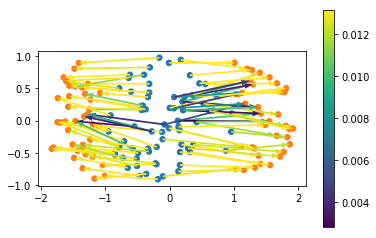

In [11]:
fh.fast(stat.probs[0].plot_link, aspect="equal")
stat.clean_last()

In [12]:
stat.test(solve_mosek_primal_simplex, log=fh.write, prog=fh.write)
stat.output_last()

Testing 0/1
Problem

  Name                   :                 

  Objective sense        : min             

  Type                   : LO (linear optimization problem)

  Constraints            : 151             

  Cones                  : 0               

  Scalar variables       : 5700            

  Matrix variables       : 0               

  Integer variables      : 0               



Optimizer started.

Simplex optimizer started.

Presolve started.

Linear dependency checker started.

Linear dependency checker terminated.

Eliminator - tries                  : 0                 time                   : 0.00            

Lin. dep.  - tries                  : 1                 time                   : 0.00            

Lin. dep.  - number                 : 0               

Presolve terminated. Time: 0.00    

Primal simplex optimizer started.

Primal simplex optimizer setup started.

Primal simplex optimizer setup terminated.

Optimizer  - solved problem         : the primal

In [13]:
stat.test(solve_mosek_dual_simplex, log=fh.write, prog=fh.write)
stat.output_last()

Testing 0/1
Problem

  Name                   :                 

  Objective sense        : min             

  Type                   : LO (linear optimization problem)

  Constraints            : 151             

  Cones                  : 0               

  Scalar variables       : 5700            

  Matrix variables       : 0               

  Integer variables      : 0               



Optimizer started.

Simplex optimizer started.

Presolve started.

Linear dependency checker started.

Linear dependency checker terminated.

Eliminator - tries                  : 0                 time                   : 0.00            

Lin. dep.  - tries                  : 1                 time                   : 0.00            

Lin. dep.  - number                 : 0               

Presolve terminated. Time: 0.00    

Dual simplex optimizer started.

Dual simplex optimizer setup started.

Dual simplex optimizer setup terminated.

Optimizer  - solved problem         : the primal      

In [14]:
stat.test(solve_mosek_interior_point, log=fh.write, prog=fh.write)
stat.output_last()

Testing 0/1
Problem

  Name                   :                 

  Objective sense        : min             

  Type                   : LO (linear optimization problem)

  Constraints            : 151             

  Cones                  : 0               

  Scalar variables       : 5700            

  Matrix variables       : 0               

  Integer variables      : 0               



Optimizer started.

Presolve started.

Linear dependency checker started.

Linear dependency checker terminated.

Eliminator - tries                  : 0                 time                   : 0.00            

Lin. dep.  - tries                  : 1                 time                   : 0.00            

Lin. dep.  - number                 : 0               

Presolve terminated. Time: 0.00    

Problem

  Name                   :                 

  Objective sense        : min             

  Type                   : LO (linear optimization problem)

  Constraints            : 151      

In [15]:
# !ConvertEnd*